In [1]:
import torch
from itertools import combinations
import numpy as np
import torch.nn.functional as F
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt

In [2]:
from fuzz.utils import enumerate_permute, gap_count
from fuzz.src.capacity import *
from fuzz.src.norm import *
from fuzz.src.choquet.choquet import *
from fuzz.src.choquet.utils import *
from fuzz.src.sim import *
from fuzz.src.knn import *
from fuzz.eval import FuzzLOO

### utils.py

In [3]:
x = torch.rand(300, 4)
print("done")
enum = enumerate_permute(x[1].unsqueeze(0))
print(enum)
print("shape", enum.shape)
gap_count(enum[0][0])

done
tensor([[[-1, -1, -1, -1],
         [ 3, -1, -1, -1],
         [ 1, -1, -1, -1],
         [ 2, -1, -1, -1],
         [ 0, -1, -1, -1],
         [ 3,  1, -1, -1],
         [ 3,  2, -1, -1],
         [ 3,  0, -1, -1],
         [ 1,  2, -1, -1],
         [ 1,  0, -1, -1],
         [ 2,  0, -1, -1],
         [ 3,  1,  2, -1],
         [ 3,  1,  0, -1],
         [ 3,  2,  0, -1],
         [ 1,  2,  0, -1],
         [ 3,  1,  2,  0]]])
shape torch.Size([1, 16, 4])


4

### capacity.py

In [4]:
mu = generate_capacity(enum[0])
for i in range(len(mu)):
    print(mu[i].get_capacity())

print(f"Capacity locator for {enum[0][4]}:", locate_capacity(enum[0][4], mu))

0
0.06081652641296387
0.0952405333518982
0.09551620483398438
0.1681884527206421
0.24733352661132812
0.38731157779693604
0.7346054911613464
0.7379869818687439
0.750916063785553
0.7950179576873779
0.8336865901947021
0.9183626770973206
0.9856711626052856
0.9967936873435974
1
Capacity locator for tensor([ 0, -1, -1, -1]): 0.1681884527206421


### norm.py

In [5]:
x = normalize(x)
print("Normalized x:\n", x)

Normalized x:
 tensor([[1.0000, 0.6944, 0.0000, 0.0911],
        [1.0000, 0.2926, 0.8012, 0.0000],
        [0.3590, 1.0000, 0.7267, 0.0000],
        ...,
        [0.6416, 0.4271, 0.0000, 1.0000],
        [0.5177, 0.0000, 0.5325, 1.0000],
        [0.3729, 1.0000, 0.0000, 0.0232]])


In [6]:
x2 = torch.rand(300,4)
x2 = normalize(x2)
x2

tensor([[1.0000, 0.8173, 0.0000, 0.9012],
        [0.6090, 0.0000, 1.0000, 0.7602],
        [0.9368, 1.0000, 0.0000, 0.6294],
        ...,
        [0.0000, 0.9658, 1.0000, 0.8391],
        [1.0000, 0.0000, 0.4286, 0.7260],
        [0.2030, 0.0000, 0.6030, 1.0000]])

In [7]:
T_norm_result = T_conorm(x, x2, mode='L')
T_norm_result

tensor([[1.0000, 1.0000, 0.0000, 0.9923],
        [1.0000, 0.2926, 1.0000, 0.7602],
        [1.0000, 1.0000, 0.7267, 0.6294],
        ...,
        [0.6416, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0000, 0.9611, 1.0000],
        [0.5760, 1.0000, 0.6030, 1.0000]])

### choquet.py

In [8]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result

tensor([[0.0000, 0.3056, 0.0000, 0.9012],
        [0.3910, 0.2926, 0.1988, 0.7602],
        [0.6410, 0.0000, 0.7267, 0.6294],
        ...,
        [0.6416, 0.5729, 1.0000, 0.1609],
        [0.4823, 0.0000, 0.5325, 0.2740],
        [0.3729, 1.0000, 0.6030, 0.9768]])

In [9]:
x[0]

tensor([1.0000, 0.6944, 0.0000, 0.0911])

In [10]:
enumerate_permute(x[0].unsqueeze(0))

tensor([[[-1, -1, -1, -1],
         [ 2, -1, -1, -1],
         [ 3, -1, -1, -1],
         [ 1, -1, -1, -1],
         [ 0, -1, -1, -1],
         [ 2,  3, -1, -1],
         [ 2,  1, -1, -1],
         [ 2,  0, -1, -1],
         [ 3,  1, -1, -1],
         [ 3,  0, -1, -1],
         [ 1,  0, -1, -1],
         [ 2,  3,  1, -1],
         [ 2,  3,  0, -1],
         [ 2,  1,  0, -1],
         [ 3,  1,  0, -1],
         [ 2,  3,  1,  0]]])

In [11]:
choquet = Choquet(X=x[0].unsqueeze(0), mu=mu)

In [12]:
choquet.choquet

tensor(0.2132)

### sim.py

In [13]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result[0].unsqueeze(0)

tensor([[0.0000, 0.3056, 0.0000, 0.9012]])

In [14]:
choquet2 = Choquet(X=s_union_result[0].unsqueeze(0), mu=mu)
choquet2.choquet

tensor(0.2340)

In [15]:
for i in range(5):
    sim = S1(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim1:", sim.score())
    sim = S2(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim2:", sim.score())
    sim = S3(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu)
    print("Sim3:", sim.score())
    print()

Sim1: tensor(0.4849)
Sim2: tensor(0.4303)
Sim3: tensor(0.4123)

Sim1: tensor(0.0221)
Sim2: tensor(0.0270)
Sim3: tensor(0.0385)

Sim1: tensor(0.6482)
Sim2: tensor(0.4515)
Sim3: tensor(0.4785)

Sim1: tensor(0.2333)
Sim2: tensor(0.2052)
Sim3: tensor(0.2830)

Sim1: tensor(0.5546)
Sim2: tensor(0.4073)
Sim3: tensor(0.4602)



### knn.py

In [16]:
label = torch.randint(0, 2, (300, ))

In [17]:
knn = KNNFuzz(input_dimension=x.size(1), mu=mu, k=3, sim=S1)
knn.fit(desc_set=x, label_set=label)
knn.accuracy(desc_set=x, label_set=label)

tensor(0.5100)

In [18]:
import time 

In [19]:
X = x 
Y = label

In [20]:
C = KNNFuzz(input_dimension=4, mu=mu, k=3, sim=S1)

In [21]:
FuzzLOO(
    C = C,
    DS = (x, label),
    mu = mu,
    time_counter=True
)

Result in 125.0144 seconds.


0.48

### eval.py

In [22]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute(x[0].unsqueeze(0))[0])

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S1), 
            DS = (x, label),
            mu=mu
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S2), 
            DS = (x, label),
            mu=mu
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S3), 
            DS = (x, label),
            mu=mu
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()

Leave one out avec k = 1


KeyboardInterrupt: 

In [17]:
nca = NCAFuzzKNN(
    input_dimension=x.size(1),
    mu = mu,
    k = 3,
    sim = S1,
    output_dimension=3
)
transformed_x = nca.transform(x)
print(transformed_x.size())
transformed_x = normalize(transformed_x)

# Regenrate mu for transformed data
mu_transformed = generate_capacity(enumerate_permute(transformed_x[0].unsqueeze(0))[0])

torch.Size([300, 3])


In [18]:
label = torch.randint(0, 2, (300, ))

In [19]:
# loss pretesting
loss = nca.loss(transformed_x, label)
print(loss)
print(f"loss.grad_fn: {loss.grad_fn}")


len(mu): 16 - m: 3
tensor(-149.5432, grad_fn=<NegBackward0>)
loss.grad_fn: <NegBackward0 object at 0x1079120b0>


In [24]:
for name, param in nca.nca.named_parameters():
    print(f"{name} requires_grad = {param.requires_grad}")

A requires_grad = True


In [ ]:
losses = nca.fit(
    desc_set=x, 
    label_set=label,
    num_epochs=100,
    learning_rate=0.01,
    batch_size=32,
)


len(mu): 16 - m: 3
loss: -16.558563232421875
len(mu): 16 - m: 3
loss: -15.566812515258789
len(mu): 16 - m: 3
loss: -16.27275276184082
len(mu): 16 - m: 3
loss: -15.666658401489258
len(mu): 16 - m: 3
loss: -16.03699493408203
len(mu): 16 - m: 3
loss: -15.623396873474121
len(mu): 16 - m: 3
loss: -15.376786231994629
len(mu): 16 - m: 3
loss: -15.514753341674805
len(mu): 16 - m: 3
loss: -16.45539093017578
len(mu): 16 - m: 3
loss: -6.224363327026367
len(mu): 16 - m: 3
loss: -16.477603912353516
len(mu): 16 - m: 3
loss: -16.95537757873535
len(mu): 16 - m: 3
loss: -15.9895601272583
len(mu): 16 - m: 3
loss: -15.48879337310791
len(mu): 16 - m: 3
loss: -15.992835998535156
len(mu): 16 - m: 3
loss: -16.04998779296875
len(mu): 16 - m: 3
loss: -17.778907775878906
len(mu): 16 - m: 3
loss: -15.926887512207031
len(mu): 16 - m: 3
loss: -15.499834060668945
len(mu): 16 - m: 3
loss: -5.344244956970215
len(mu): 16 - m: 3
loss: -16.001419067382812
len(mu): 16 - m: 3
loss: -15.727029800415039
len(mu): 16 - m: 3
l

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Training Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

#### Test compute pij

In [21]:
pij = nca.compute_pij(transformed_x)

len(mu): 16 - m: 3


<Axes: >

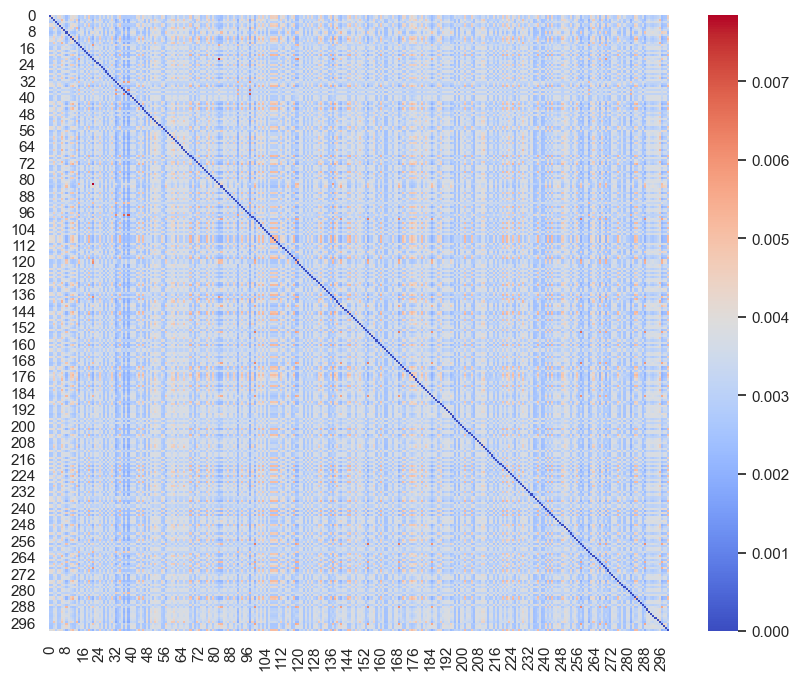

In [23]:
test = pij.detach().numpy()
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(test, fmt=".2f", cmap='coolwarm')

#### NCA loss

In [ ]:
optimizer = torch.optim.Adam([nca.nca.A], lr=1e-3)

In [ ]:
for i in range(5):
    print("Epoch", i)
    epoch_loss = 0
    # Shuffle the data for mini-batch training
    indices = torch.randperm(10)

    # Mini-batch training
    for start_idx in range(0, 10, 21):
        # Get mini-batch indices
        batch_indices = indices[start_idx:min(start_idx + 21, 10)]

        # Get batch data
        batch_x = x[batch_indices]
        batch_y = label[batch_indices]

        # Regenerate mu for transformed data
        mu_transformed = generate_capacity(enumerate_permute(batch_x[0].unsqueeze(0))[0])

        # Zero the gradients
        # optimizer.zero_grad()

        # Compute loss
        loss = nca.loss(x=batch_x, labels=batch_y)
        print("Loss:", loss.item())

        # Backward pass and optimization
        # loss.backward()
        # optimizer.step()
        
        epoch_loss += loss.item() * len(batch_indices)
    

In [ ]:
print(transformed_x.min(), transformed_x.max())

In [ ]:
n = transformed_x.size(0)
sim_matrix = torch.zeros((n, n))

mu_transformed = generate_capacity(enumerate_permute(transformed_x[0].unsqueeze(0))[0])


In [ ]:
for i in range(n):
    for j in range(n):
        if i != j:  # Exclude self-similarity
            sim_matrix[i, j] = S1(transformed_x[i].unsqueeze(0), transformed_x[j].unsqueeze(0), mu_transformed).score()

In [ ]:
test = sim_matrix.numpy()
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(test, fmt=".2f", cmap='coolwarm')

In [ ]:
mask = torch.eye(n, dtype=torch.bool)
sim_matrix.masked_fill_(mask, float('-inf'))  # Set diagonal to -inf

In [ ]:
pij = torch.softmax(sim_matrix, dim=1)

In [ ]:
test = pij.numpy()
import seaborn as sns
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(test, fmt=".2f", cmap='coolwarm')